In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import Model

In [ ]:
PATH1 = '/content/drive/MyDrive/words/words'

In [ ]:
PATH2 = '/content/words.txt'

In [ ]:
def preprocessWord(word): # count accomodates for the epsilon value in between repeating letters.
  count = 1
  for i in range(1,len(word)):
    
    if(word[i]!=word[i-1]):
      count+=1
    else:
      count+=2 # for the epsilon to be inserted
    # print(count, word[:i])
    if count>=32: #32 is the max length of the timestep.
      word = word[:i]
      break

  return word

a = preprocessWord("Gaitskelljkjgspppppppppppppppppp")

In [ ]:
import os

f = open(PATH2, "r")
img_path = []
word = []
#['a01-117-05-02', 'r06-022-03-05'] #These files in the main dataset are corrupted
vocab = set()

for i, line in enumerate(f):
  if(line[0]=='#'):
    continue #doesn't execute the rest of the block, goes to the next iteration of the loop
  else:
    line = line.strip().split() #.strip used for removing trailing white spaces. The statement splits each sentence into words
    # if len(line)>9: # some 'words' in the dataset have 2 words. so concatenate them using a space.
    #   print(" ".join(line[8:]))
    #   print(line[8:], len(line))
    if line[0] in ['a01-117-05-02', 'r06-022-03-05']:
      continue
    start = line[0].split('-')
    path = os.path.join(PATH1, start[0], start[0]+'-'+start[1], line[0]+'.png') # Gets image paths 
    img_path.append(path)
    preproc_word = preprocessWord(" ".join(line[8:]))
    word.append(preproc_word)
    letters = set(list(preproc_word))
    vocab = vocab.union(letters)
    
# print(img_path[0:20])
# print(word[0:20])
print(len(vocab))

79


In [ ]:
max_str_len = max([len(x) for x in word]) # 32: timesteps. Different from max string length

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(img_path, word, test_size=0.1, random_state=42)

(72, 106, 3)
grey


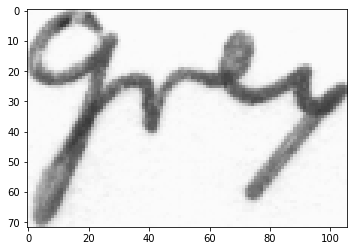

In [ ]:
path0 = X_train[10]
w = y_train[10]
import matplotlib.pyplot as plt
import cv2
img1 = cv2.imread(path0)
print(img1.shape)
plt.imshow(img1)
print(w)

In [ ]:
layer = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocab), num_oov_indices=0, mask_token=None)

def input_pipeline(file_path, label):
  img = tf.io.read_file(file_path) #img will be byte-like object. Decode it to get a numpy array
  img = tf.io.decode_png(img) #gives numpy array
  img = tf.image.resize_with_pad(img, 32, 128)
  img = tf.image.transpose(img) # for time-series data so that we get character-wise feature maps.
  img = img/255.0
  
  label = layer(tf.strings.unicode_split(label, 'UTF-8')) # splits into a list of characters
  label_length = tf.shape(label)
  label = tf.pad(label, [[0, max_str_len-label_length[0]]], constant_values=-99) 
  return {'InputImage': img, 'y_true': label, 'label_length':label_length} #return as dict to feed 
                                  # into pipeline. key names are the input layer names.
# img, label = input_pipeline(path0, w)
# img = tf.squeeze(img, -1)*255.0 #to get pixel values for visualization
# print(img)
# # plt.imshow(img.numpy().astype('uint8'), cmap='gray')
# plt.imshow(img.numpy(), cmap='gray')
# print(label)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(len(X_train)).map(
        input_pipeline, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(128).prefetch(
            tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).shuffle(len(X_test)).map(
        input_pipeline, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(128).prefetch(
            tf.data.experimental.AUTOTUNE)

In [ ]:
for d in test_ds.take(1):
  x, y, z = d['InputImage'], d['y_true'], d['label_length']
  print(x.shape, y.shape, z.shape)


(128, 128, 32, 1) (128, 21) (128, 1)


In [ ]:
class ctcLayer(tf.keras.layers.Layer): # In custom loss, y_true and y_pred have to have the same shape
  def __init__(self, **kwargs):        # And we can only take in y_true, y_pred and sample weights(weight the samples).
    super().__init__(**kwargs)         # That's why we use a custom layer
    self.loss_fn = tf.keras.backend.ctc_batch_cost #reduce_sum happens inside this

  def call(self, y_true, y_pred, label_length):
    timesteps = tf.cast(tf.shape(y_pred)[1], tf.int64)
    batch_len = tf.cast(tf.shape(y_pred)[0], tf.int64)
    input_length = timesteps*tf.ones((batch_len, 1), dtype=tf.int64)
    label_length = tf.cast(label_length, tf.int64)
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss) #function of tf.keras.layers.Layer
    return y_pred # needed for inference to pass into ctc decoder

  def get_config(self):
    base_config = super().get_config()
    return {**base_config}

In [ ]:
# x = tf.keras.Input(shape=(128, 64, 1))
x = tf.keras.Input(shape=(128, 32, 1), name='InputImage')
conv1 = tf.keras.layers.Conv2D(32, (5,5), padding='same',activation='relu',kernel_initializer='he_uniform', name='conv1')(x)
maxpool1 = tf.keras.layers.MaxPooling2D(2, name='maxpool1')(conv1)

conv2 = tf.keras.layers.Conv2D(64, (5,5), padding='same',activation='relu', name='conv2')(maxpool1)
maxpool2 = tf.keras.layers.MaxPooling2D(2, name='maxpool2')(conv2)

conv3 = tf.keras.layers.Conv2D(128, (3,3), padding='same',activation='relu', name='conv3')(maxpool2)
maxpool3 = tf.keras.layers.MaxPooling2D(pool_size=(1,2), name='maxpool3')(conv3)

conv4 = tf.keras.layers.Conv2D(128, (3,3), padding='same',activation='relu', name='conv4')(maxpool3)
maxpool4 = tf.keras.layers.MaxPooling2D(pool_size=(1,2), name='maxpool4')(conv4)

conv5 = tf.keras.layers.Conv2D(256, (3,3), padding='same', name='conv5')(maxpool4)
maxpool5 = tf.keras.layers.MaxPooling2D(pool_size=(1,2), name='maxpool5')(conv5)
bn1 = tf.keras.layers.BatchNormalization()(maxpool5)
act = tf.keras.layers.Activation('relu')(bn1)
# conv6 = tf.keras.layers.Conv2D(512, (3,3), padding='same',activation='relu', name='conv6')(bn1)
# bn2 = tf.keras.layers.BatchNormalization()(conv6)
# maxpool4 = tf.keras.layers.MaxPooling2D(pool_size=(1,2), strides=(2,2), name='maxpool4')(bn2)
# conv7 = tf.keras.layers.Conv2D(512, (2,2), padding='valid',activation='relu', name='conv7')(maxpool4)
#Need to design custom model.

reshape = tf.keras.layers.Reshape((32, 256))(act)
bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2), name='bilstm1')(reshape)
bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2), name='bilstm2')(bilstm1)

dense = tf.keras.layers.Dense(80, activation='softmax', kernel_initializer='he_normal', name='dense')(bilstm2)
y_true = tf.keras.Input((None,), name='y_true')
label_length = tf.keras.Input((None,), name='label_length')
losslayer = ctcLayer()(y_true, dense, label_length)
model1 = tf.keras.Model(inputs=[x, y_true, label_length], outputs=losslayer)

In [ ]:
input_length = tf.constant(32, dtype='int64')*tf.cast(tf.ones((32, 1)), tf.int64)

In [ ]:
input_length

<tf.Tensor: shape=(32, 1), dtype=int64, numpy=
array([[32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32],
       [32]])>

In [ ]:
model1.compile(optimizer='adam', loss=None)

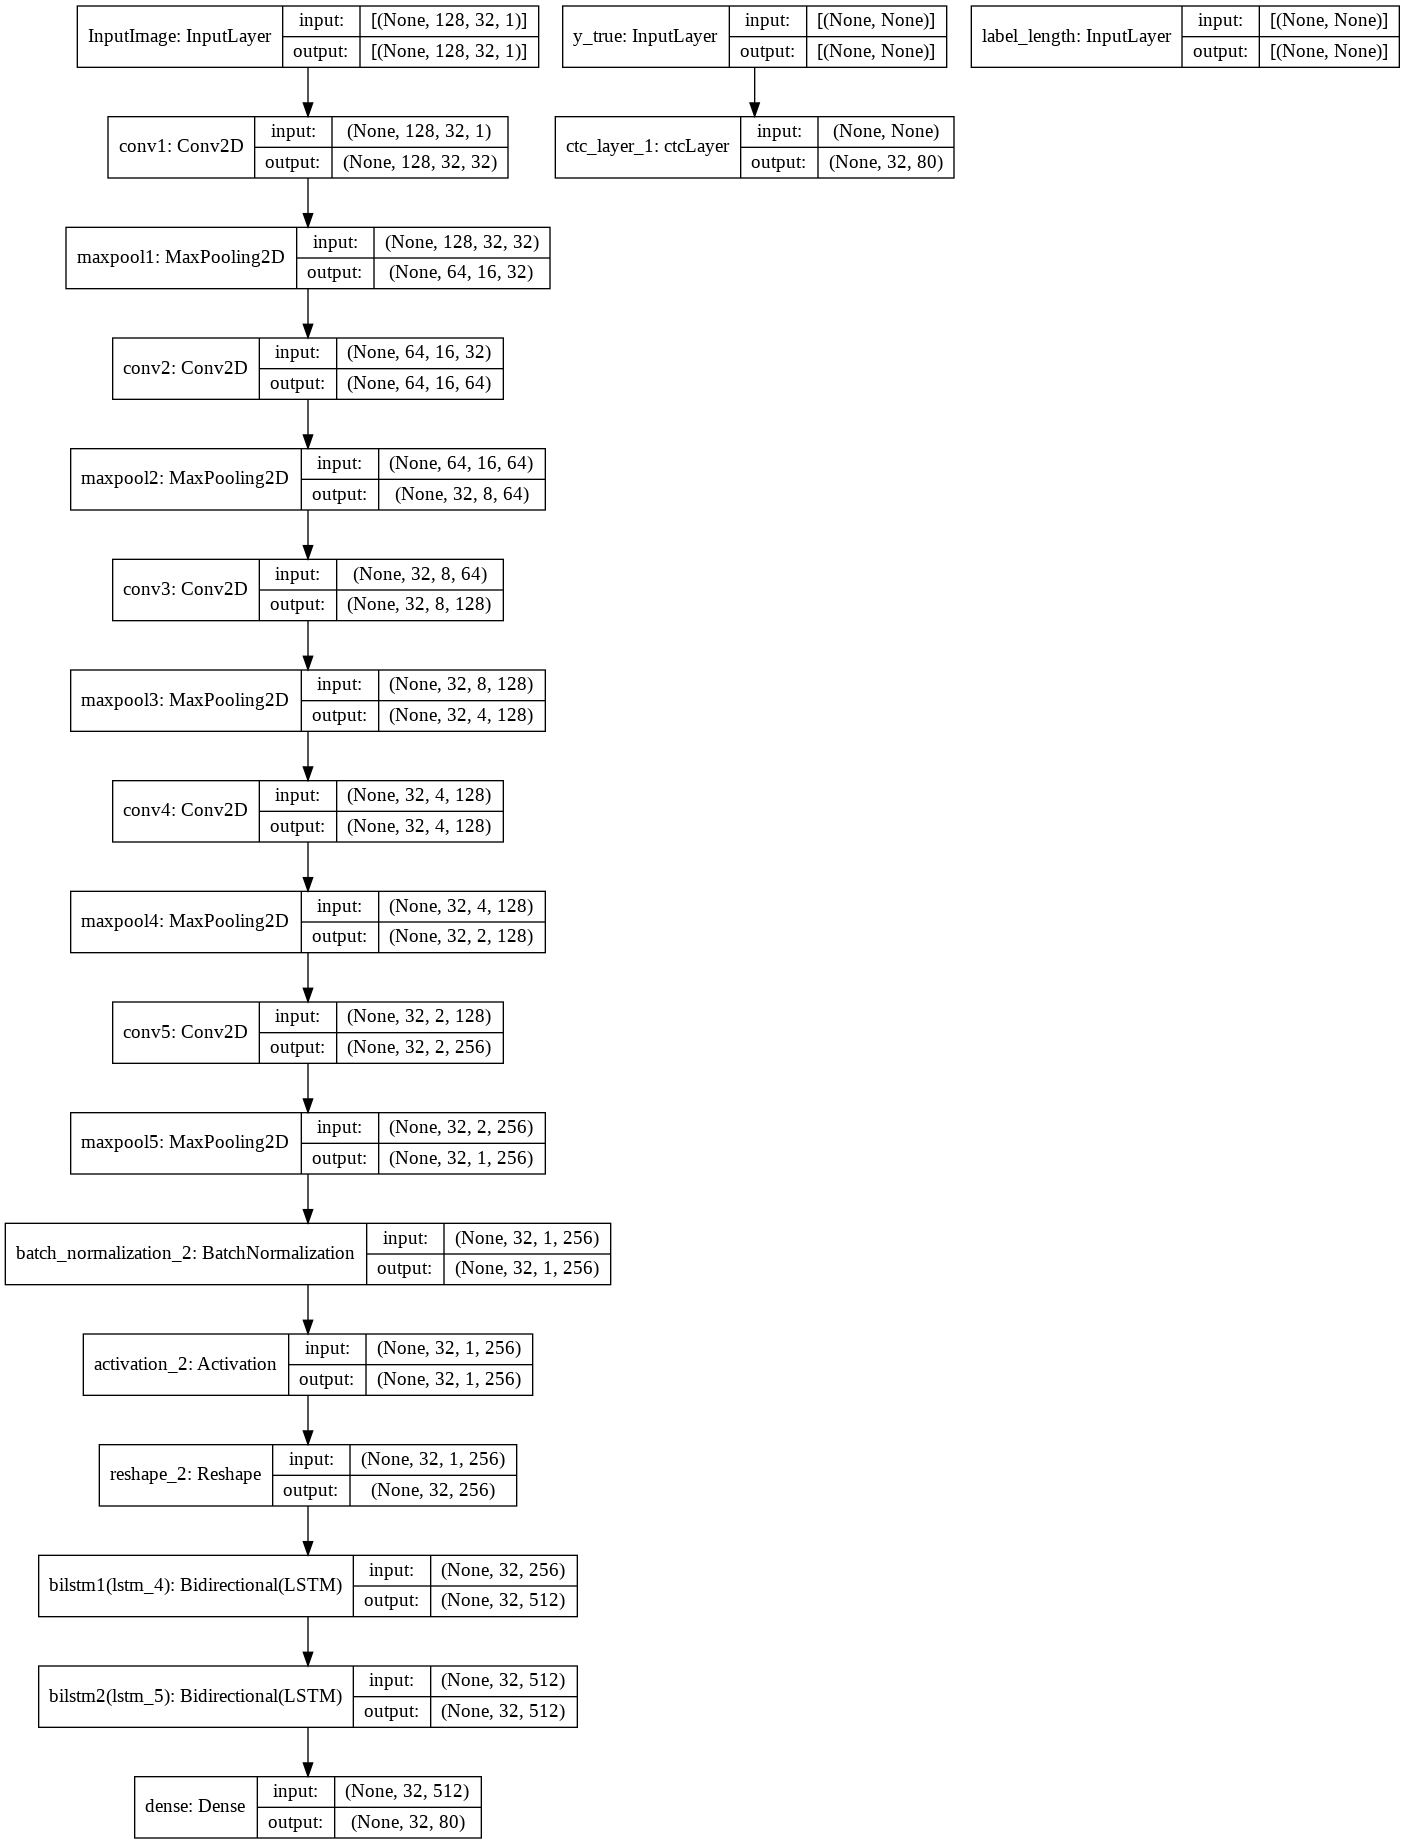

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model1.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/20
811/811 [==============================] - 15915s 20s/step - loss: 14.4444 - val_loss: 12.9202
Epoch 2/20
695/811 [========================>.....] - ETA: 8:39 - loss: 5.5561

In [ ]:
!nvidia-smi

Reloading trained model and decoding outputs-- converting numbers to letters to words.

In [ ]:
arr = np.random.uniform(0, 1, (128, 32, 80)) #Just used for testing purposes

In [ ]:
model_pred = tf.keras.models.Model(inputs=model1.get_layer(name='InputImage').input, 
                                   outputs = model1.get_layer(name='dense').output)

In [ ]:
# layer = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocab), 
#                                                                 num_oov_indices=0, mask_token=None, oov_token="")
layer = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocab), 
                                                                num_oov_indices=1, mask_token=None, invert=True,
                                                                oov_token="")
def decode_batch_pred(preds):
  input_length = preds.shape[1]*tf.ones((preds.shape[0]), dtype=tf.int64)
  results, probs = tf.keras.backend.ctc_decode(preds, input_length=input_length)
  preds_ = results[0][:,:21]
  aa = []
  for i in range(len(preds_)):
    # temp = np.array([99]*21)
    word = tf.strings.reduce_join(layer(preds_[i])).numpy().decode('UTF-8')
    # word = tf.strings.reduce_join(layer(temp)).numpy().decode('UTF-8')
    print(word)
    # aa.append()
  # print(results)
decode_batch_pred(arr)